In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import mean_squared_error

In [2]:
# Import everything from glucose_transformer
from glucose_transformer import (
    TimeSeriesDataset,
    TransformerEncoder,
    load_ohio_series_train,
    create_population_splits,
    create_loocv_splits,
    create_4fold_splits,
    split_into_continuous_series,
    create_train_val_datasets,
    train_model,
    evaluate_model,
    evaluate_and_save_metrics_population,
    evaluate_and_save_metrics,
    save_model,
    load_model
)

# Train on Ohio dataset

## Population data

In [3]:
folder_path_train_2018 = f"./OhioT1DM 2020/2018/train"
folder_path_train_2020 = "./OhioT1DM 2020/2020/train"
train_files_2018 = [f for f in os.listdir(folder_path_train_2018) if f.endswith('.xml')]
train_files_2020 = [f for f in os.listdir(folder_path_train_2020) if f.endswith('.xml')]

folder_path_test_2018 = f"./OhioT1DM 2020/2018/test"
folder_path_test_2020 = "./OhioT1DM 2020/2020/test"
test_files_2018 = [f for f in os.listdir(folder_path_test_2018) if f.endswith('.xml')]
test_files_2020 = [f for f in os.listdir(folder_path_test_2020) if f.endswith('.xml')]

# 2. Create LOOCV splits
population_splits = create_population_splits(
    folder_path_train_2018,
    folder_path_train_2020,
    train_files_2018,
    train_files_2020,
    folder_path_test_2018,
    folder_path_test_2020,
    test_files_2018,
    test_files_2020
)

print(population_splits)

Test file: ['./OhioT1DM 2020/2018/test/559-ws-testing.xml', './OhioT1DM 2020/2018/test/588-ws-testing.xml', './OhioT1DM 2020/2018/test/570-ws-testing.xml', './OhioT1DM 2020/2018/test/563-ws-testing.xml', './OhioT1DM 2020/2018/test/591-ws-testing.xml', './OhioT1DM 2020/2018/test/575-ws-testing.xml', './OhioT1DM 2020/2020/test/552-ws-testing.xml', './OhioT1DM 2020/2020/test/540-ws-testing.xml', './OhioT1DM 2020/2020/test/544-ws-testing.xml', './OhioT1DM 2020/2020/test/596-ws-testing.xml', './OhioT1DM 2020/2020/test/584-ws-testing.xml', './OhioT1DM 2020/2020/test/567-ws-testing.xml']
Number of training files: 12
Training files:
  575-ws-training.xml
  563-ws-training.xml
  559-ws-training.xml
{'train': ['./OhioT1DM 2020/2018/train/575-ws-training.xml', './OhioT1DM 2020/2018/train/563-ws-training.xml', './OhioT1DM 2020/2018/train/559-ws-training.xml', './OhioT1DM 2020/2018/train/588-ws-training.xml', './OhioT1DM 2020/2018/train/570-ws-training.xml', './OhioT1DM 2020/2018/train/591-ws-train

In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4. Set hyperparameters
past_sequence_length = 12
future_offset = 6
batch_size = 64
max_interval_minutes = 30

# 5. Train model
model = TransformerEncoder(
    num_layers=1,
    d_model=512,
    nhead=4,
    input_dim=1,
    dim_feedforward=256,
    dropout=0.2
)
model = model.to(device)

# Load and process training data
train_dfs = []
for train_file in population_splits['train']:
    df = load_ohio_series_train(train_file, "glucose_level", "value")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    train_dfs.append(df)

# Create datasets
train_series_list = []
for df in train_dfs:
    series_list = split_into_continuous_series(df, past_sequence_length, future_offset, max_interval_minutes)
    train_series_list.extend(series_list)

train_dataset, val_dataset = create_train_val_datasets(
    train_series_list,
    train_ratio=0.8,
    past_seq_len=past_sequence_length,
    future_offset=future_offset
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Train model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=200,
    learning_rate=1e-3
)

# Evaluate on test data
metrics = evaluate_and_save_metrics(
    model=model,
    test_file_path=population_splits['test'],
    save_dir='evaluation_metrics',
    past_sequence_length=past_sequence_length,
    future_offset=future_offset,
    batch_size=batch_size,
    max_interval_minutes=max_interval_minutes
)

# Save the trained model
save_model(model, 'population', save_dir='saved_models_original_ohio')

print(f"RMSE: {metrics['rmse']:.2f}")
print(f"MAE: {metrics['mae']:.2f}")
print(f"MAPE: {metrics['mape']:.2f}%")

/Users/yanjuncui/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4019.281787, Val Loss: 3798.844578
Epoch [6/200], Train Loss: 2141.972260, Val Loss: 1169.941826
Epoch [11/200], Train Loss: 728.496391, Val Loss: 517.528085
Epoch [16/200], Train Loss: 665.125336, Val Loss: 715.006715
Epoch [21/200], Train Loss: 729.080397, Val Loss: 539.276325
Epoch [26/200], Train Loss: 667.133946, Val Loss: 734.044068
Epoch [31/200], Train Loss: 663.102933, Val Loss: 742.383974
Epoch [36/200], Train Loss: 649.891509, Val Loss: 578.839167
Epoch [41/200], Train Loss: 553.999856, Val Loss: 502.242474
Epoch [46/200], Train Loss: 553.975103, Val Loss: 502.278559
Epoch [51/200], Train Loss: 570.241133, Val Loss: 504.246841
Epoch [56/200], Train Loss: 573.129709, Val Loss: 599.425781
Epoch [61/200], Train Loss: 562.878802, Val Loss: 553.339865
Epoch [66/200], Train Loss: 551.378526, Val Loss: 498.160792
Epoch [71/200], Train Loss: 566.611317, Val Loss: 497.937275
Epoch [76/200], Train Loss: 551.007175, Val Loss: 618.450532
Epoch [81/200], Train 

FileNotFoundError: [Errno 2] No such file or directory: "['./OhioT1DM 2020/2018/test/559-ws-testing.xml', './OhioT1DM 2020/2018/test/588-ws-testing.xml', './OhioT1DM 2020/2018/test/570-ws-testing.xml', './OhioT1DM 2020/2018/test/563-ws-testing.xml', './OhioT1DM 2020/2018/test/591-ws-testing.xml', './OhioT1DM 2020/2018/test/575-ws-testing.xml', './OhioT1DM 2020/2020/test/552-ws-testing.xml', './OhioT1DM 2020/2020/test/540-ws-testing.xml', './OhioT1DM 2020/2020/test/544-ws-testing.xml', './OhioT1DM 2020/2020/test/596-ws-testing.xml', './OhioT1DM 2020/2020/test/584-ws-testing.xml', './OhioT1DM 2020/2020/test/567-ws-testing.xml']"

(31743, 2)
Test file: population
Root Mean Square Error (RMSE): 33.57
Mean Absolute Error (MAE): 20.67
Mean Absolute Percentage Error (MAPE): 14.80%


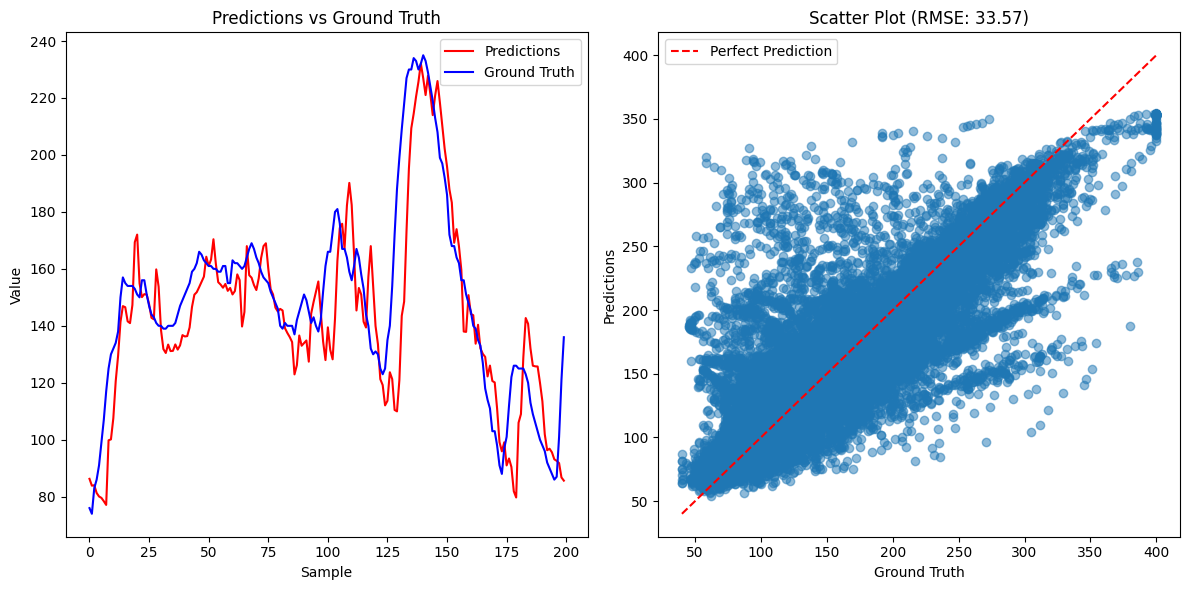

Model saved to saved_models_original_ohio/model_population.pth
RMSE: 33.57
MAE: 20.67
MAPE: 14.80%


In [13]:
# 4. Set hyperparameters
past_sequence_length = 12
future_offset = 6
batch_size = 64
max_interval_minutes = 30
test_eval = []

# Evaluate on test data
metrics = evaluate_and_save_metrics_population(
    model=model,
    test_file_path=population_splits['test'],
    save_dir='evaluation_metrics',
    past_sequence_length=past_sequence_length,
    future_offset=future_offset,
    batch_size=batch_size,
    max_interval_minutes=max_interval_minutes
)

# Save the trained model
save_model(model, 'population', save_dir='saved_models_original_ohio')

print(f"RMSE: {metrics['rmse']:.2f}")
print(f"MAE: {metrics['mae']:.2f}")
print(f"MAPE: {metrics['mape']:.2f}%")

Model loaded from saved_models_original_ohio/model_population.pth
./OhioT1DM 2020/2018/test/559-ws-testing.xml
Test file: 559-ws-testing.xml
Root Mean Square Error (RMSE): 21.90
Mean Absolute Error (MAE): 15.21
Mean Absolute Percentage Error (MAPE): 9.25%


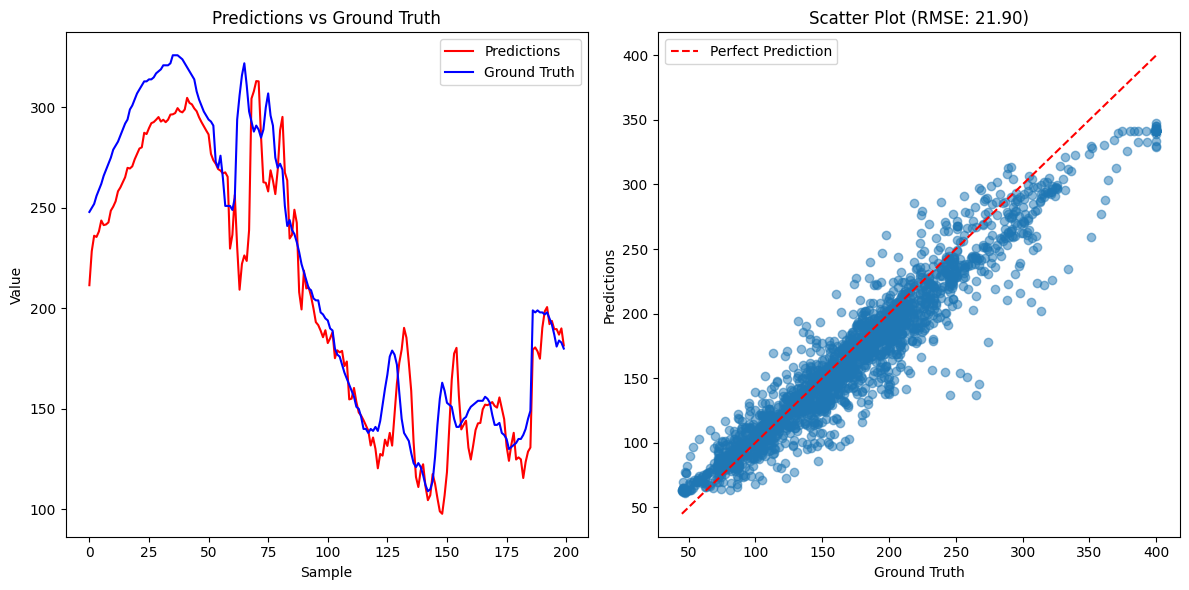


Results for population model:
RMSE: 21.90
MAE: 15.21
MAPE: 9.25%
./OhioT1DM 2020/2018/test/588-ws-testing.xml
Test file: 588-ws-testing.xml
Root Mean Square Error (RMSE): 20.10
Mean Absolute Error (MAE): 14.53
Mean Absolute Percentage Error (MAPE): 8.44%


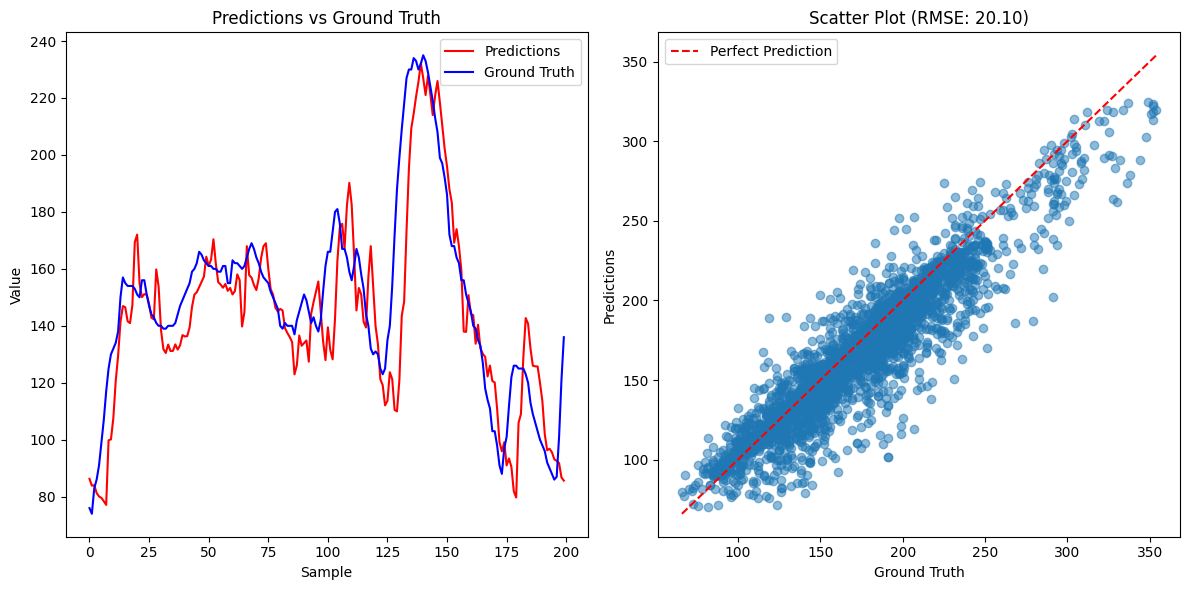


Results for population model:
RMSE: 20.10
MAE: 14.53
MAPE: 8.44%
./OhioT1DM 2020/2018/test/570-ws-testing.xml
Test file: 570-ws-testing.xml
Root Mean Square Error (RMSE): 20.56
Mean Absolute Error (MAE): 15.61
Mean Absolute Percentage Error (MAPE): 7.33%


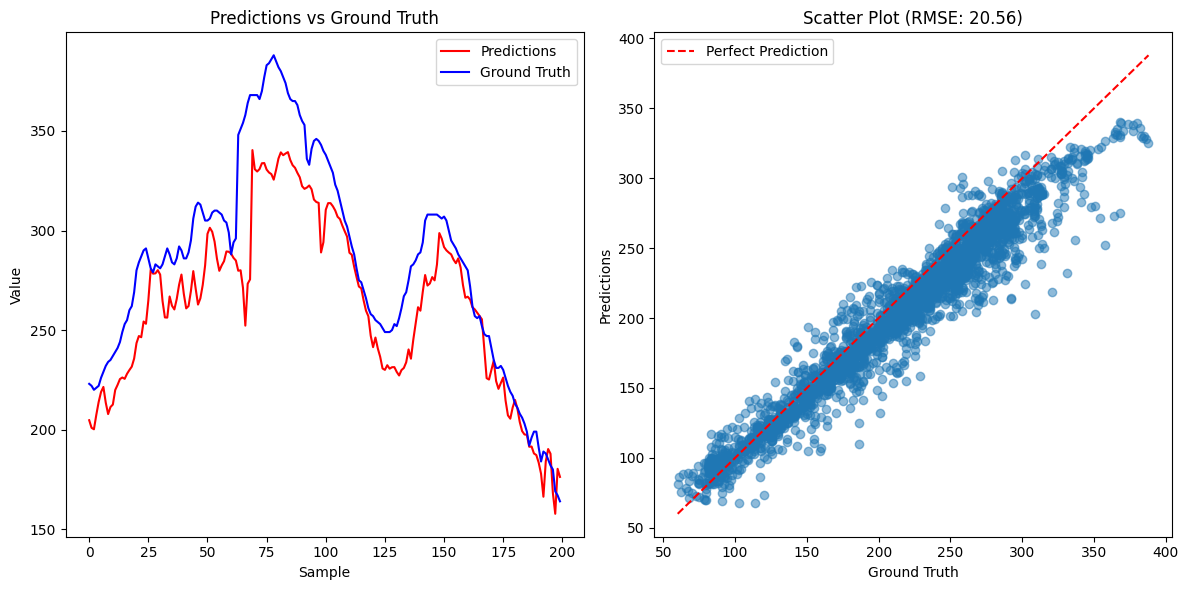


Results for population model:
RMSE: 20.56
MAE: 15.61
MAPE: 7.33%
./OhioT1DM 2020/2018/test/563-ws-testing.xml
Test file: 563-ws-testing.xml
Root Mean Square Error (RMSE): 19.39
Mean Absolute Error (MAE): 13.84
Mean Absolute Percentage Error (MAPE): 8.48%


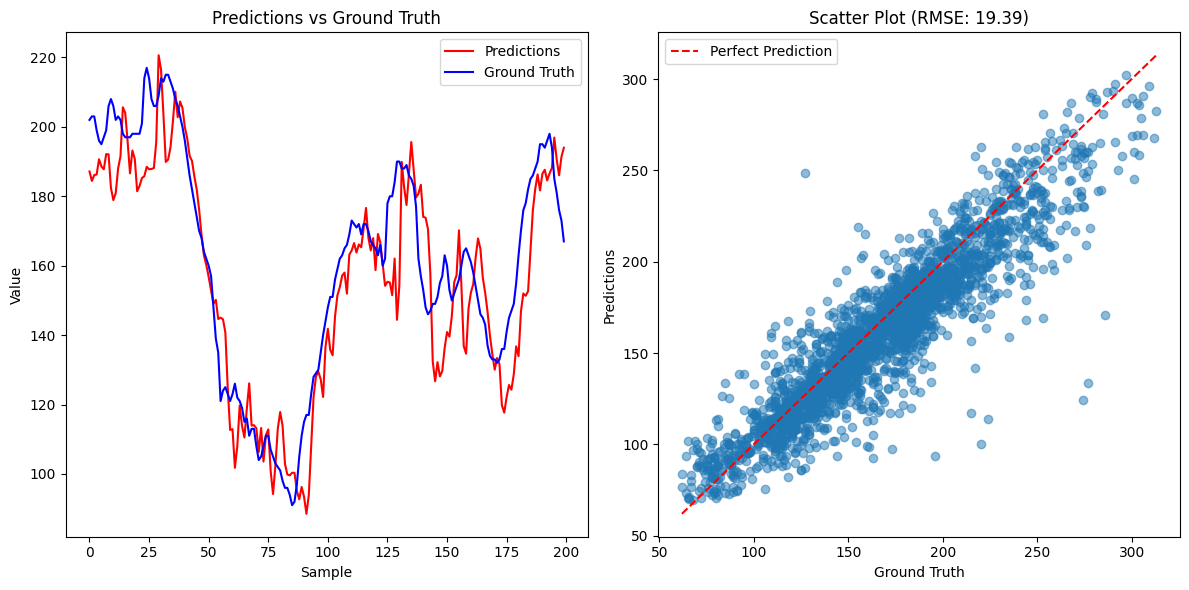


Results for population model:
RMSE: 19.39
MAE: 13.84
MAPE: 8.48%
./OhioT1DM 2020/2018/test/591-ws-testing.xml
Test file: 591-ws-testing.xml
Root Mean Square Error (RMSE): 21.82
Mean Absolute Error (MAE): 15.83
Mean Absolute Percentage Error (MAPE): 11.81%


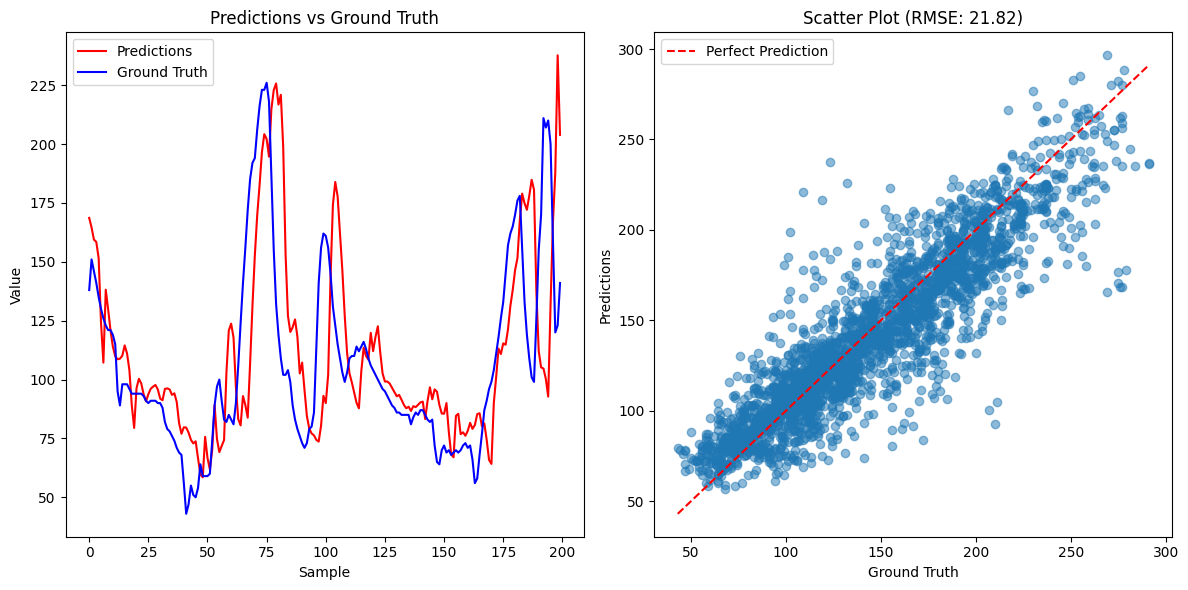


Results for population model:
RMSE: 21.82
MAE: 15.83
MAPE: 11.81%
./OhioT1DM 2020/2018/test/575-ws-testing.xml
Test file: 575-ws-testing.xml
Root Mean Square Error (RMSE): 23.86
Mean Absolute Error (MAE): 15.68
Mean Absolute Percentage Error (MAPE): 11.06%


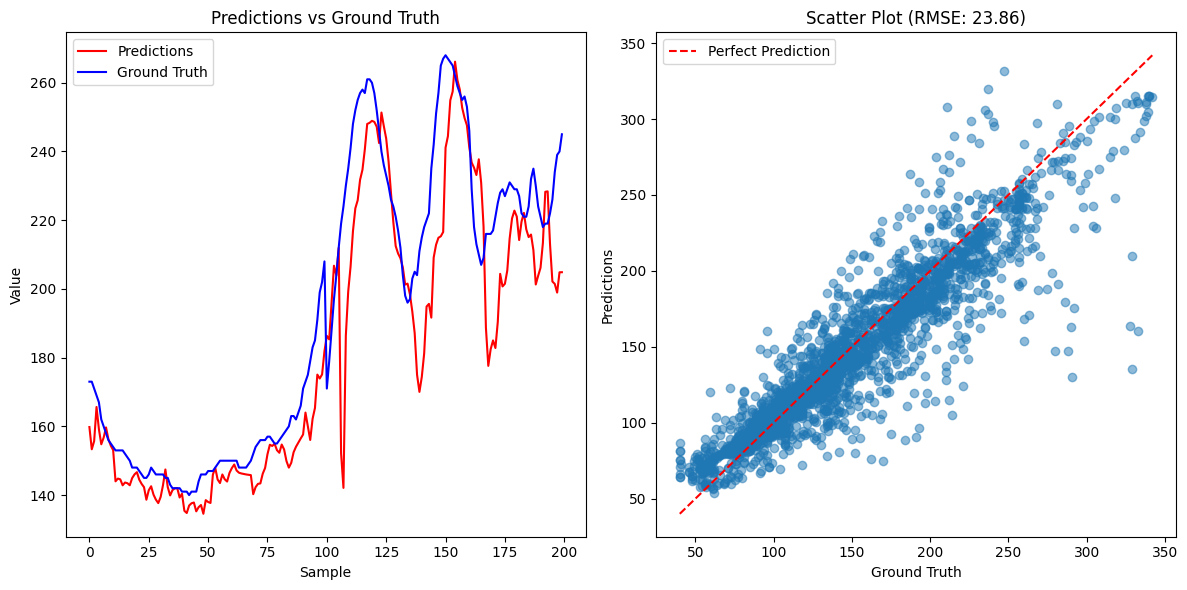


Results for population model:
RMSE: 23.86
MAE: 15.68
MAPE: 11.06%
./OhioT1DM 2020/2020/test/552-ws-testing.xml
Test file: 552-ws-testing.xml
Root Mean Square Error (RMSE): 17.17
Mean Absolute Error (MAE): 12.94
Mean Absolute Percentage Error (MAPE): 9.78%


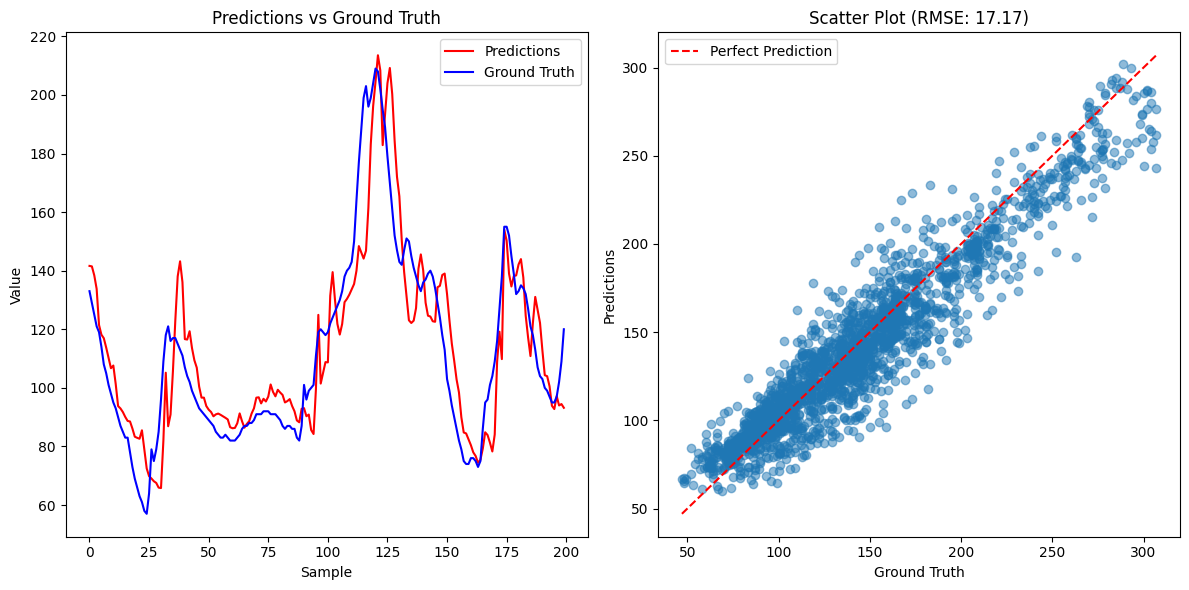


Results for population model:
RMSE: 17.17
MAE: 12.94
MAPE: 9.78%
./OhioT1DM 2020/2020/test/540-ws-testing.xml
Test file: 540-ws-testing.xml
Root Mean Square Error (RMSE): 23.80
Mean Absolute Error (MAE): 17.64
Mean Absolute Percentage Error (MAPE): 11.91%


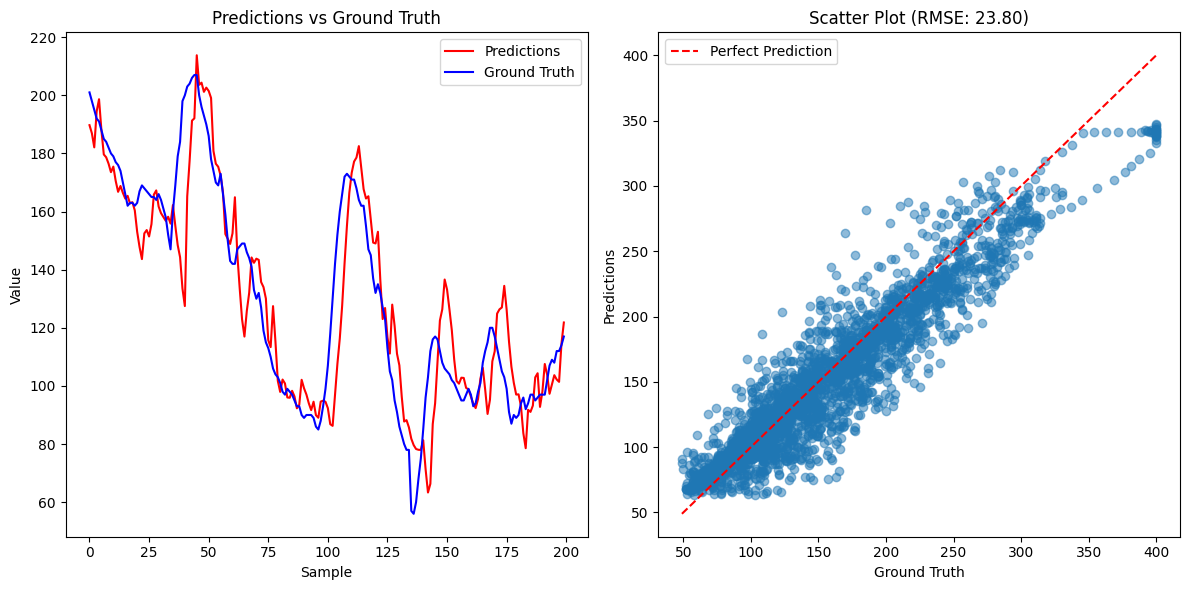


Results for population model:
RMSE: 23.80
MAE: 17.64
MAPE: 11.91%
./OhioT1DM 2020/2020/test/544-ws-testing.xml
Test file: 544-ws-testing.xml
Root Mean Square Error (RMSE): 19.25
Mean Absolute Error (MAE): 13.45
Mean Absolute Percentage Error (MAPE): 8.70%


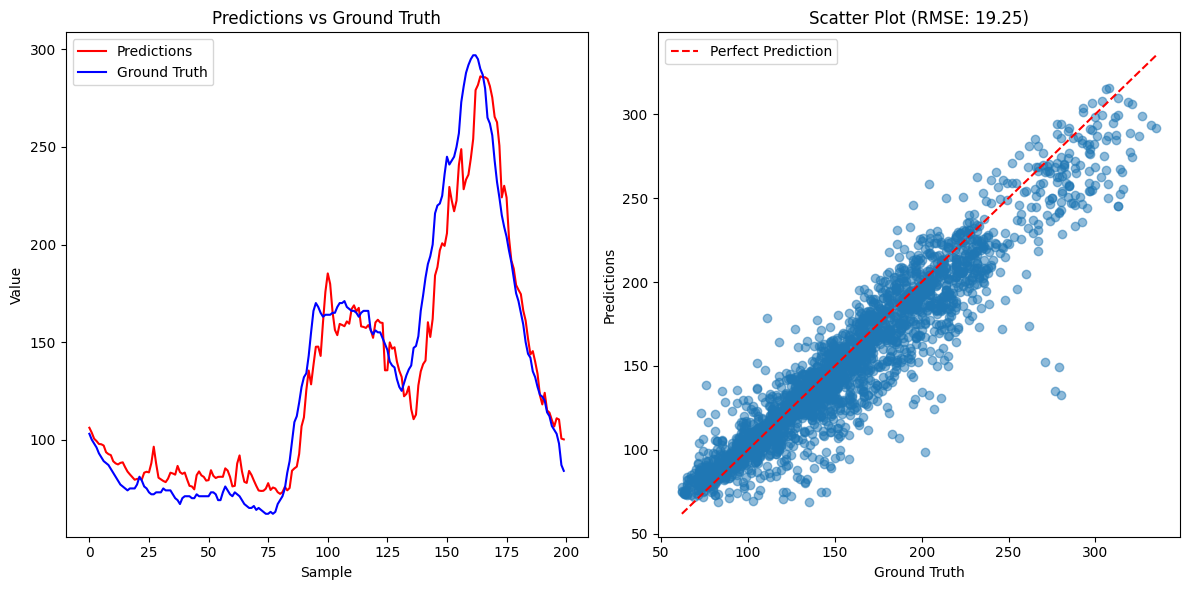


Results for population model:
RMSE: 19.25
MAE: 13.45
MAPE: 8.70%
./OhioT1DM 2020/2020/test/596-ws-testing.xml
Test file: 596-ws-testing.xml
Root Mean Square Error (RMSE): 17.64
Mean Absolute Error (MAE): 12.58
Mean Absolute Percentage Error (MAPE): 8.98%


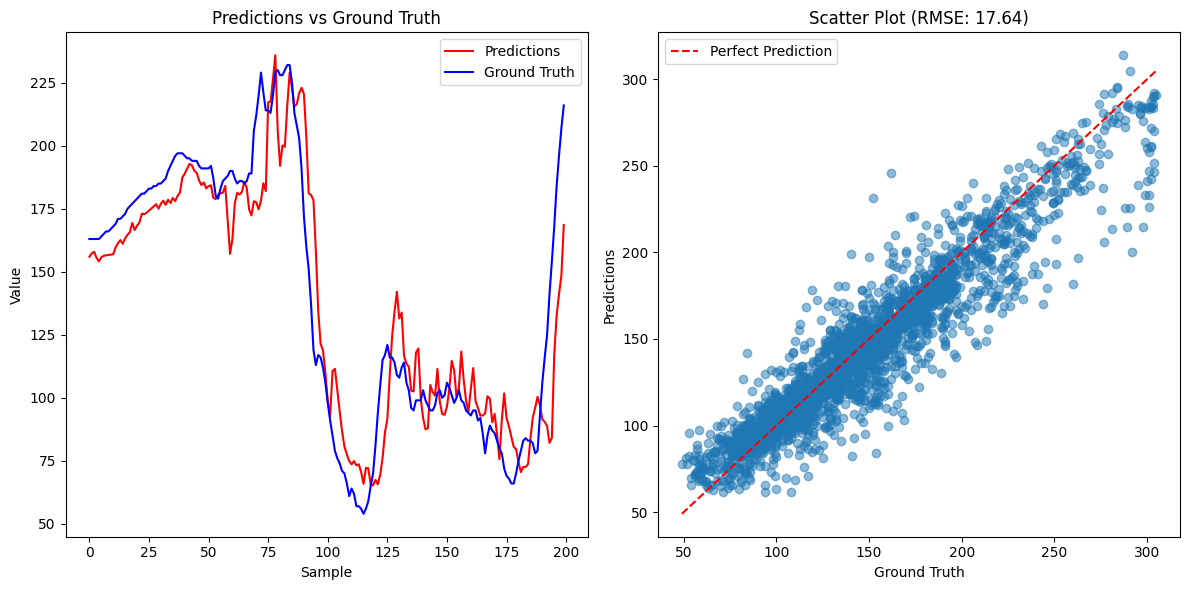


Results for population model:
RMSE: 17.64
MAE: 12.58
MAPE: 8.98%
./OhioT1DM 2020/2020/test/584-ws-testing.xml
Test file: 584-ws-testing.xml
Root Mean Square Error (RMSE): 24.12
Mean Absolute Error (MAE): 17.03
Mean Absolute Percentage Error (MAPE): 10.36%


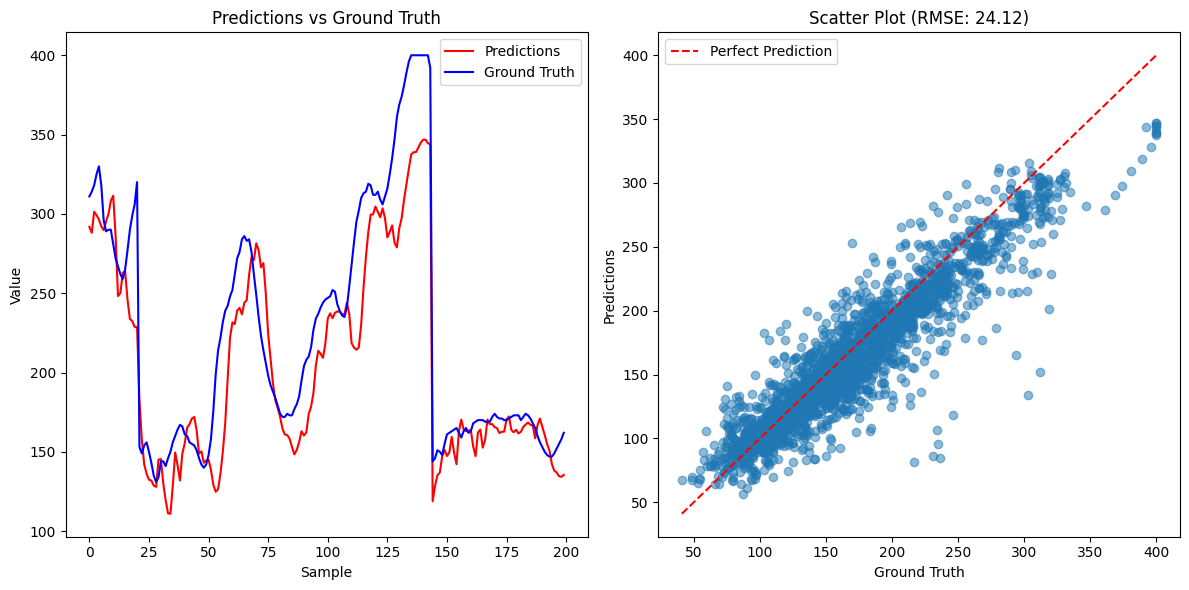


Results for population model:
RMSE: 24.12
MAE: 17.03
MAPE: 10.36%
./OhioT1DM 2020/2020/test/567-ws-testing.xml
Test file: 567-ws-testing.xml
Root Mean Square Error (RMSE): 21.80
Mean Absolute Error (MAE): 15.45
Mean Absolute Percentage Error (MAPE): 11.00%


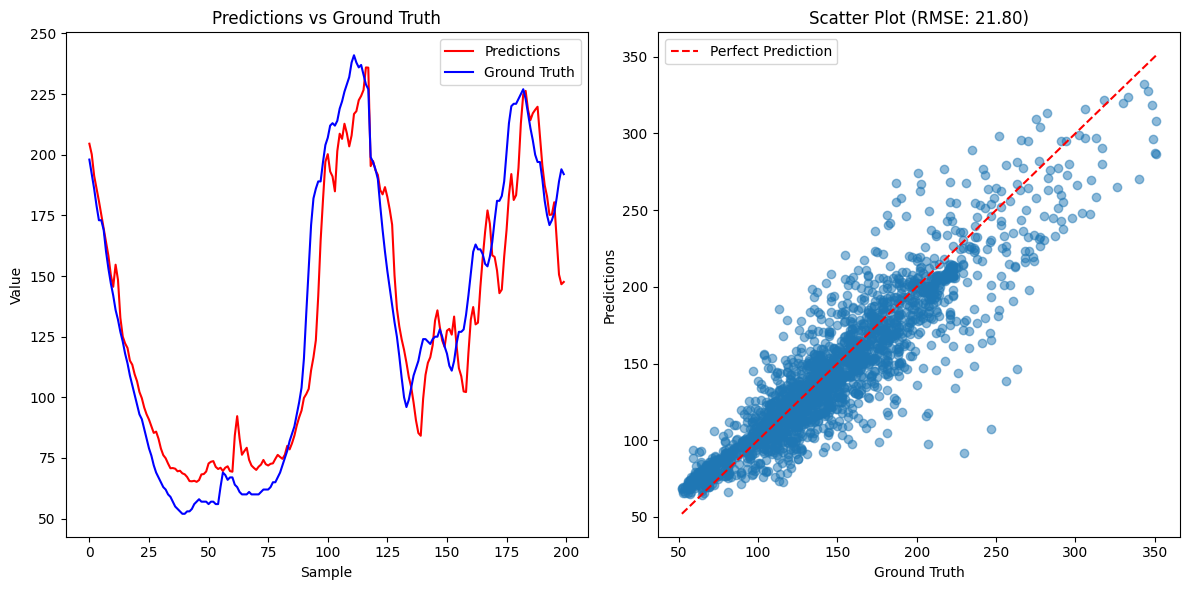


Results for population model:
RMSE: 21.80
MAE: 15.45
MAPE: 11.00%


In [10]:
# Load the saved model
model = load_model('population', save_dir='saved_models_original_ohio')

# 4. Set hyperparameters
past_sequence_length = 12
future_offset = 6
batch_size = 64
max_interval_minutes = 30
test_eval = []

for test in population_splits['test']:
    print(test)
    # Evaluate on test data individually 
    metrics = evaluate_and_save_metrics(
        model=model,
        test_file_path=test,
        save_dir='evaluation_metrics',
        past_sequence_length=past_sequence_length,
        future_offset=future_offset,
        batch_size=batch_size,
        max_interval_minutes=max_interval_minutes
    )

    id = test.split('/')[-1].split('-')[0]
    test_eval.append([id, round(metrics['rmse'], 2), round(metrics['mae'], 2), round(metrics['mape'], 2)])

    # print(f"\nResults for population model:")
    print(f"RMSE: {metrics['rmse']:.2f}")
    print(f"MAE: {metrics['mae']:.2f}")
    print(f"MAPE: {metrics['mape']:.2f}%")

In [12]:
print(test_eval)
df = pd.DataFrame(test_eval, columns=['test patient', 'RMSE', 'MAE', 'MAPE'])
df.to_csv('./evaluation_metrics/individual_test_eval.csv', index=False)

[['559', 21.9, 15.21, 9.25], ['588', 20.1, 14.53, 8.44], ['570', 20.56, 15.61, 7.33], ['563', 19.39, 13.84, 8.48], ['591', 21.82, 15.83, 11.81], ['575', 23.86, 15.68, 11.06], ['552', 17.17, 12.94, 9.78], ['540', 23.8, 17.64, 11.91], ['544', 19.25, 13.45, 8.7], ['596', 17.64, 12.58, 8.98], ['584', 24.12, 17.03, 10.36], ['567', 21.8, 15.45, 11.0]]


## Leave-one-out

Created 12 LOOCV splits

fold1:
Test file: 559-ws-training.xml
Number of training files: 11
Training files:
  563-ws-training.xml
  570-ws-training.xml
  575-ws-training.xml
  ...

fold2:
Test file: 563-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  570-ws-training.xml
  575-ws-training.xml
  ...

fold3:
Test file: 570-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  563-ws-training.xml
  575-ws-training.xml
  ...

fold4:
Test file: 575-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  563-ws-training.xml
  570-ws-training.xml
  ...

fold5:
Test file: 588-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  563-ws-training.xml
  570-ws-training.xml
  ...

fold6:
Test file: 591-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  563-ws-training.xml
  570-ws-training.xml
  ...

fold7:
Test file: 540-ws-training.xml
N

c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4199.284624, Val Loss: 4003.429665
Epoch [6/200], Train Loss: 2625.470409, Val Loss: 1483.284002
Epoch [11/200], Train Loss: 746.237131, Val Loss: 1033.584264
Epoch [16/200], Train Loss: 673.593915, Val Loss: 570.280063
Epoch [21/200], Train Loss: 844.911793, Val Loss: 772.951657
Epoch [26/200], Train Loss: 604.519628, Val Loss: 544.733888
Epoch [31/200], Train Loss: 600.461402, Val Loss: 593.980021
Epoch [36/200], Train Loss: 620.749893, Val Loss: 524.253233
Epoch [41/200], Train Loss: 558.988449, Val Loss: 504.500198
Epoch [46/200], Train Loss: 560.250688, Val Loss: 515.132305
Epoch [51/200], Train Loss: 554.949365, Val Loss: 512.042085
Epoch [56/200], Train Loss: 536.305474, Val Loss: 501.311361
Epoch [61/200], Train Loss: 535.495003, Val Loss: 491.739208
Epoch [66/200], Train Loss: 539.107245, Val Loss: 490.016111
Epoch [71/200], Train Loss: 542.539657, Val Loss: 527.892021
Epoch [76/200], Train Loss: 538.589754, Val Loss: 508.419665
Epoch [81/200], Train

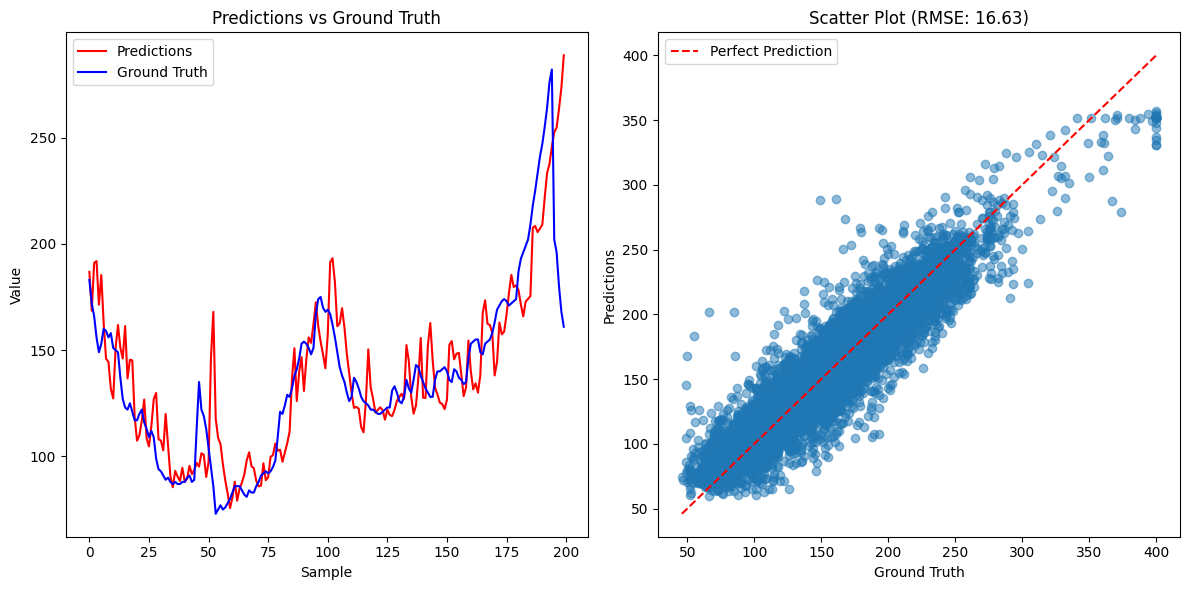

Model saved to saved_models_original_ohio\model_563-ws-training.xml.pth

Results for fold2:
RMSE: 16.63
MAE: 12.07
MAPE: 9.05%

Processing fold3...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 3929.957876, Val Loss: 3788.041460
Epoch [6/200], Train Loss: 2113.719477, Val Loss: 3148.958633
Epoch [11/200], Train Loss: 749.360721, Val Loss: 934.868454
Epoch [16/200], Train Loss: 672.738228, Val Loss: 515.733027
Epoch [21/200], Train Loss: 705.648228, Val Loss: 756.435033
Epoch [26/200], Train Loss: 695.092020, Val Loss: 634.256794
Epoch [31/200], Train Loss: 659.327991, Val Loss: 532.970147
Epoch [36/200], Train Loss: 582.637858, Val Loss: 536.154164
Epoch [41/200], Train Loss: 573.598070, Val Loss: 551.861207
Epoch [46/200], Train Loss: 585.274126, Val Loss: 521.007985
Early stopping triggered
Test file: 570-ws-training.xml
Root Mean Square Error (RMSE): 20.78
Mean Absolute Error (MAE): 15.39
Mean Absolute Percentage Error (MAPE): 8.81%


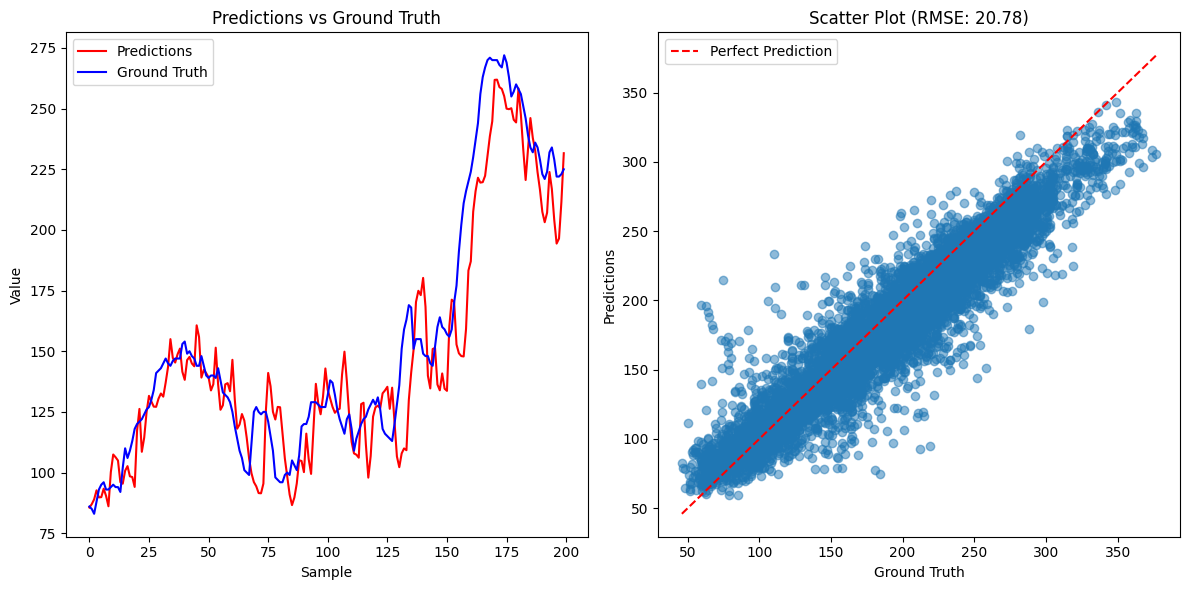

Model saved to saved_models_original_ohio\model_570-ws-training.xml.pth

Results for fold3:
RMSE: 20.78
MAE: 15.39
MAPE: 8.81%

Processing fold4...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4316.913929, Val Loss: 3767.281689
Epoch [6/200], Train Loss: 2089.121147, Val Loss: 1224.847056
Epoch [11/200], Train Loss: 894.754095, Val Loss: 552.532707
Epoch [16/200], Train Loss: 730.406459, Val Loss: 755.580188
Epoch [21/200], Train Loss: 701.829387, Val Loss: 1409.952522
Epoch [26/200], Train Loss: 697.300315, Val Loss: 658.820108
Epoch [31/200], Train Loss: 597.034971, Val Loss: 535.596773
Epoch [36/200], Train Loss: 598.449719, Val Loss: 504.960518
Epoch [41/200], Train Loss: 591.493320, Val Loss: 545.631477
Epoch [46/200], Train Loss: 594.282221, Val Loss: 599.484695
Epoch [51/200], Train Loss: 545.340642, Val Loss: 489.396338
Epoch [56/200], Train Loss: 549.280504, Val Loss: 556.163307
Epoch [61/200], Train Loss: 545.369777, Val Loss: 495.583922
Epoch [66/200], Train Loss: 529.579537, Val Loss: 484.909643
Epoch [71/200], Train Loss: 532.239866, Val Loss: 505.079025
Epoch [76/200], Train Loss: 530.163720, Val Loss: 489.035618
Epoch [81/200], Train

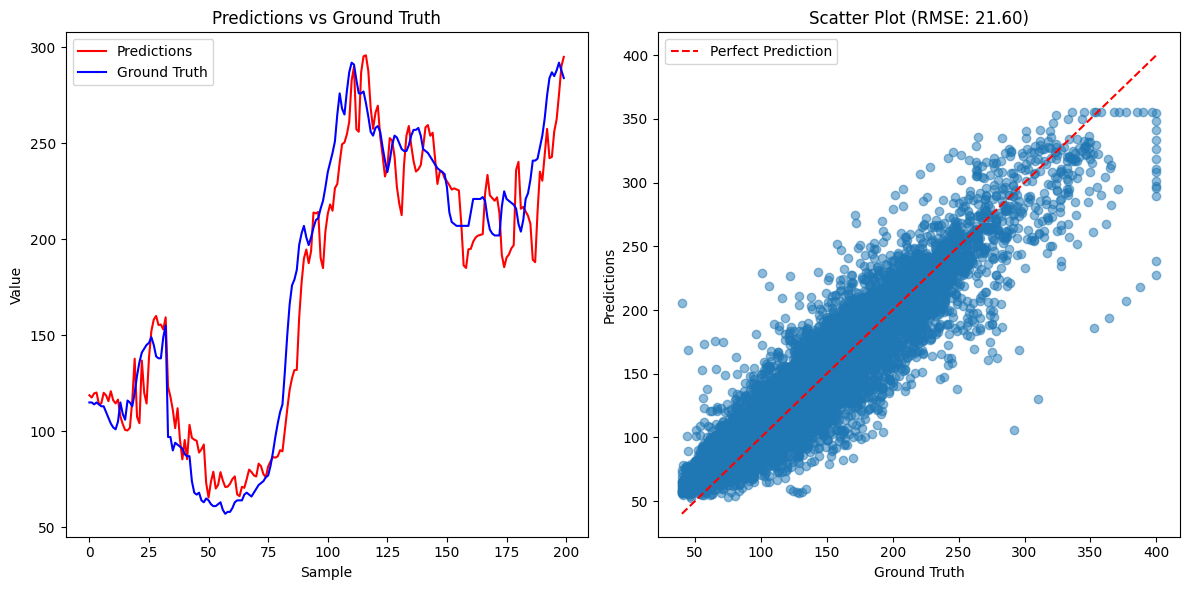

Model saved to saved_models_original_ohio\model_575-ws-training.xml.pth

Results for fold4:
RMSE: 21.60
MAE: 15.27
MAPE: 12.36%

Processing fold5...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4203.277485, Val Loss: 3895.254256
Epoch [6/200], Train Loss: 1394.914115, Val Loss: 1131.204999
Epoch [11/200], Train Loss: 666.825616, Val Loss: 1111.538157
Epoch [16/200], Train Loss: 640.056283, Val Loss: 547.211721
Epoch [21/200], Train Loss: 641.307760, Val Loss: 531.430646
Epoch [26/200], Train Loss: 634.500953, Val Loss: 534.321022
Epoch [31/200], Train Loss: 632.777246, Val Loss: 619.468179
Epoch [36/200], Train Loss: 573.922775, Val Loss: 489.687804
Epoch [41/200], Train Loss: 570.091915, Val Loss: 504.062888
Epoch [46/200], Train Loss: 567.438590, Val Loss: 557.321923
Epoch [51/200], Train Loss: 582.024432, Val Loss: 524.896666
Epoch [56/200], Train Loss: 542.062638, Val Loss: 478.287671
Epoch [61/200], Train Loss: 540.496788, Val Loss: 470.093944
Epoch [66/200], Train Loss: 540.388315, Val Loss: 474.355039
Epoch [71/200], Train Loss: 541.477672, Val Loss: 471.031885
Epoch [76/200], Train Loss: 521.095416, Val Loss: 518.470378
Epoch [81/200], Train

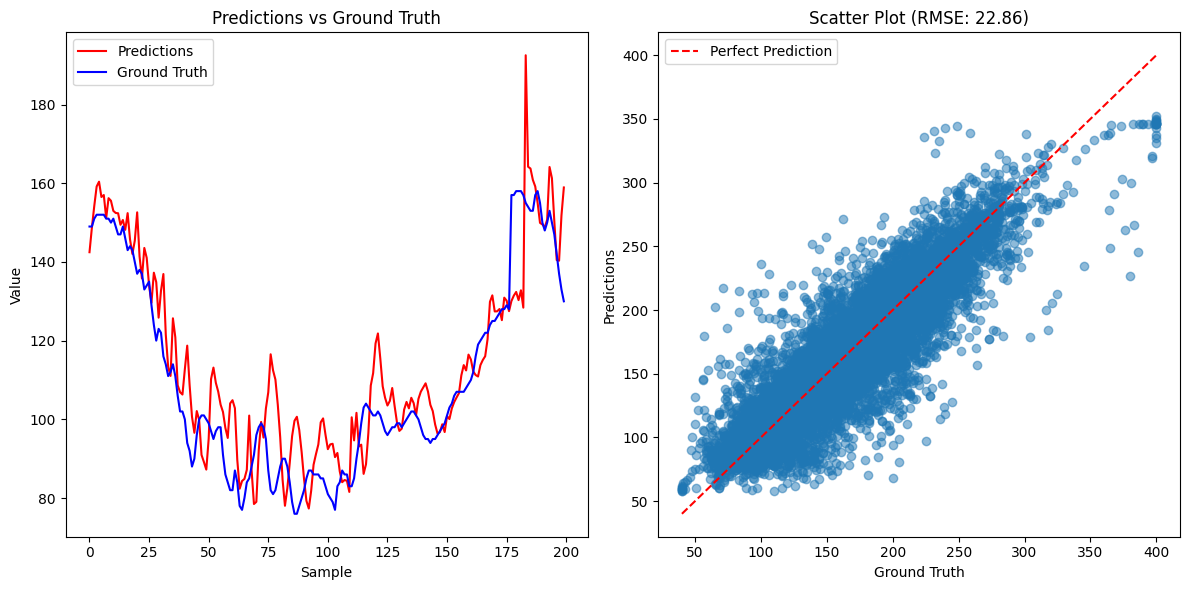

Model saved to saved_models_original_ohio\model_588-ws-training.xml.pth

Results for fold5:
RMSE: 22.86
MAE: 15.91
MAPE: 10.57%

Processing fold6...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4142.062660, Val Loss: 3774.843346
Epoch [6/200], Train Loss: 1153.380417, Val Loss: 664.749910
Epoch [11/200], Train Loss: 713.701472, Val Loss: 663.363472
Epoch [16/200], Train Loss: 682.302477, Val Loss: 480.230177
Epoch [21/200], Train Loss: 751.646901, Val Loss: 503.533682
Epoch [26/200], Train Loss: 683.163796, Val Loss: 489.465953
Epoch [31/200], Train Loss: 579.867462, Val Loss: 498.736648
Epoch [36/200], Train Loss: 585.451827, Val Loss: 509.000843
Epoch [41/200], Train Loss: 530.399309, Val Loss: 478.035700
Epoch [46/200], Train Loss: 542.172334, Val Loss: 459.664743
Epoch [51/200], Train Loss: 531.285013, Val Loss: 520.819203
Epoch [56/200], Train Loss: 540.320602, Val Loss: 465.111775
Epoch [61/200], Train Loss: 540.435140, Val Loss: 491.549459
Epoch [66/200], Train Loss: 516.009035, Val Loss: 457.671317
Epoch [71/200], Train Loss: 518.970568, Val Loss: 465.568168
Epoch [76/200], Train Loss: 516.387482, Val Loss: 483.662030
Epoch [81/200], Train L

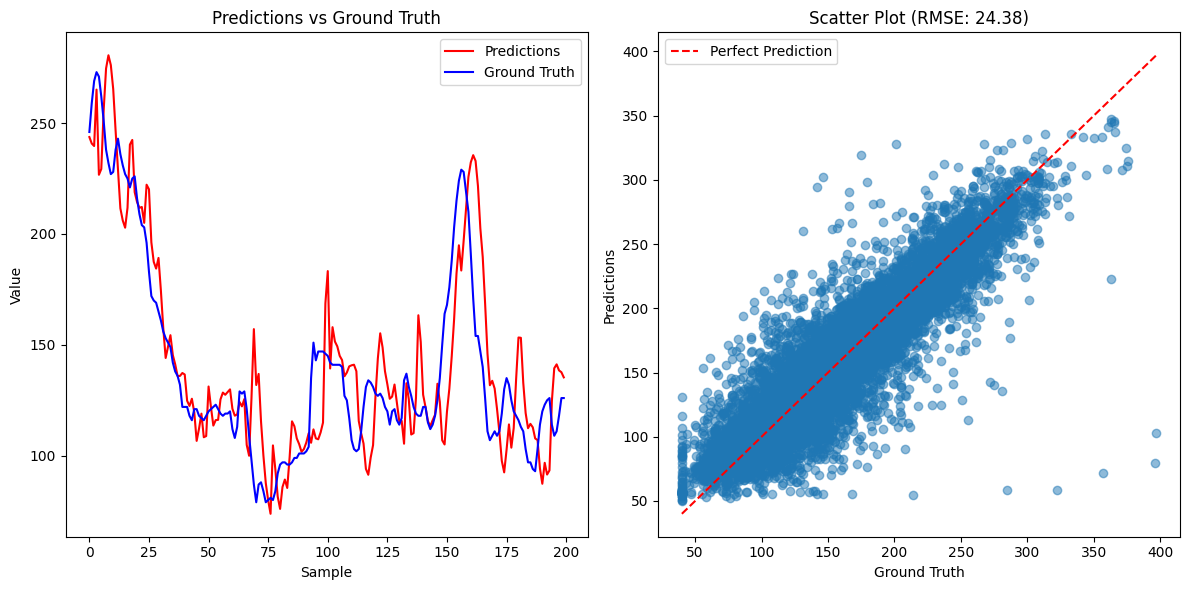

Model saved to saved_models_original_ohio\model_591-ws-training.xml.pth

Results for fold6:
RMSE: 24.38
MAE: 16.98
MAPE: 12.74%

Processing fold7...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4106.049711, Val Loss: 3790.568096
Epoch [6/200], Train Loss: 823.847621, Val Loss: 807.537946
Epoch [11/200], Train Loss: 670.873997, Val Loss: 716.092903
Epoch [16/200], Train Loss: 714.441044, Val Loss: 1835.714119
Epoch [21/200], Train Loss: 640.163705, Val Loss: 574.393228
Epoch [26/200], Train Loss: 570.483887, Val Loss: 531.569978
Epoch [31/200], Train Loss: 581.914143, Val Loss: 503.384279
Epoch [36/200], Train Loss: 561.881636, Val Loss: 500.971002
Epoch [41/200], Train Loss: 571.508905, Val Loss: 486.137372
Epoch [46/200], Train Loss: 559.793730, Val Loss: 536.356304
Epoch [51/200], Train Loss: 531.900661, Val Loss: 492.207502
Epoch [56/200], Train Loss: 533.915806, Val Loss: 513.312555
Epoch [61/200], Train Loss: 538.256862, Val Loss: 486.778099
Epoch [66/200], Train Loss: 539.595051, Val Loss: 499.284214
Epoch [71/200], Train Loss: 518.729891, Val Loss: 478.138042
Epoch [76/200], Train Loss: 519.234210, Val Loss: 478.996141
Epoch [81/200], Train L

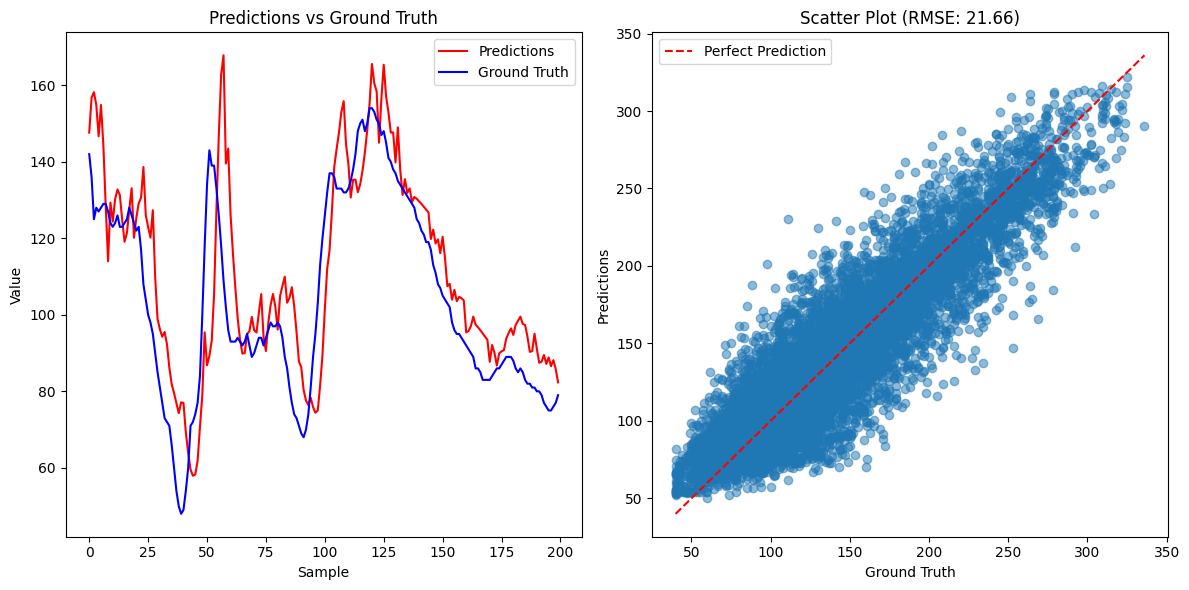

Model saved to saved_models_original_ohio\model_540-ws-training.xml.pth

Results for fold7:
RMSE: 21.66
MAE: 16.07
MAPE: 13.34%

Processing fold8...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4014.201265, Val Loss: 3860.091186
Epoch [6/200], Train Loss: 3647.703184, Val Loss: 3857.379375
Epoch [11/200], Train Loss: 1012.292915, Val Loss: 594.163337
Epoch [16/200], Train Loss: 691.135121, Val Loss: 909.346374
Epoch [21/200], Train Loss: 722.330422, Val Loss: 703.016295
Epoch [26/200], Train Loss: 622.967963, Val Loss: 576.523991
Epoch [31/200], Train Loss: 571.271914, Val Loss: 699.953474
Epoch [36/200], Train Loss: 568.975365, Val Loss: 529.481565
Epoch [41/200], Train Loss: 583.322759, Val Loss: 532.743440
Epoch [46/200], Train Loss: 575.518477, Val Loss: 516.965673
Epoch [51/200], Train Loss: 570.152955, Val Loss: 514.086687
Epoch [56/200], Train Loss: 544.595465, Val Loss: 521.871201
Epoch [61/200], Train Loss: 538.852128, Val Loss: 571.485848
Epoch [66/200], Train Loss: 537.993516, Val Loss: 504.896261
Epoch [71/200], Train Loss: 538.407114, Val Loss: 489.774041
Epoch [76/200], Train Loss: 535.897212, Val Loss: 525.427417
Epoch [81/200], Train

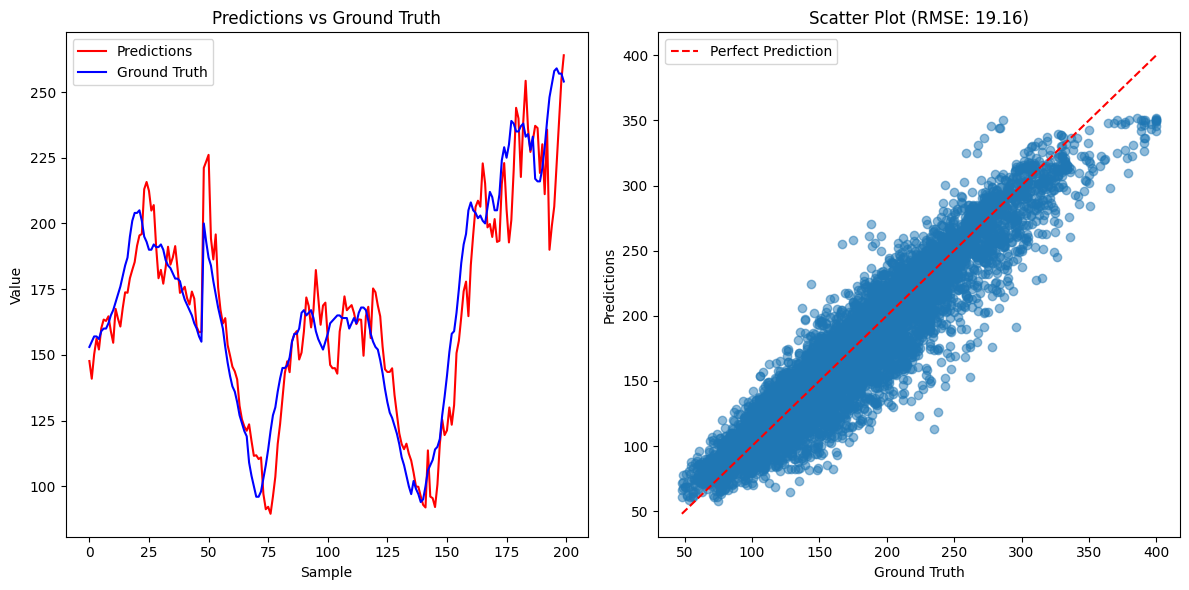

Model saved to saved_models_original_ohio\model_544-ws-training.xml.pth

Results for fold8:
RMSE: 19.16
MAE: 13.87
MAPE: 8.86%

Processing fold9...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4086.240872, Val Loss: 3776.175615
Epoch [6/200], Train Loss: 1033.700429, Val Loss: 1050.712999
Epoch [11/200], Train Loss: 859.586576, Val Loss: 656.873267
Epoch [16/200], Train Loss: 671.339052, Val Loss: 1013.397791
Epoch [21/200], Train Loss: 635.385512, Val Loss: 581.670088
Epoch [26/200], Train Loss: 645.040988, Val Loss: 519.052360
Epoch [31/200], Train Loss: 581.526745, Val Loss: 508.973413
Epoch [36/200], Train Loss: 574.112504, Val Loss: 492.079379
Epoch [41/200], Train Loss: 576.459808, Val Loss: 507.960147
Epoch [46/200], Train Loss: 579.210189, Val Loss: 534.037962
Epoch [51/200], Train Loss: 538.861438, Val Loss: 495.220099
Epoch [56/200], Train Loss: 546.278614, Val Loss: 481.404055
Epoch [61/200], Train Loss: 542.802555, Val Loss: 479.081937
Epoch [66/200], Train Loss: 539.569525, Val Loss: 523.364399
Epoch [71/200], Train Loss: 540.671341, Val Loss: 499.830292
Epoch [76/200], Train Loss: 538.706614, Val Loss: 542.366396
Epoch [81/200], Train

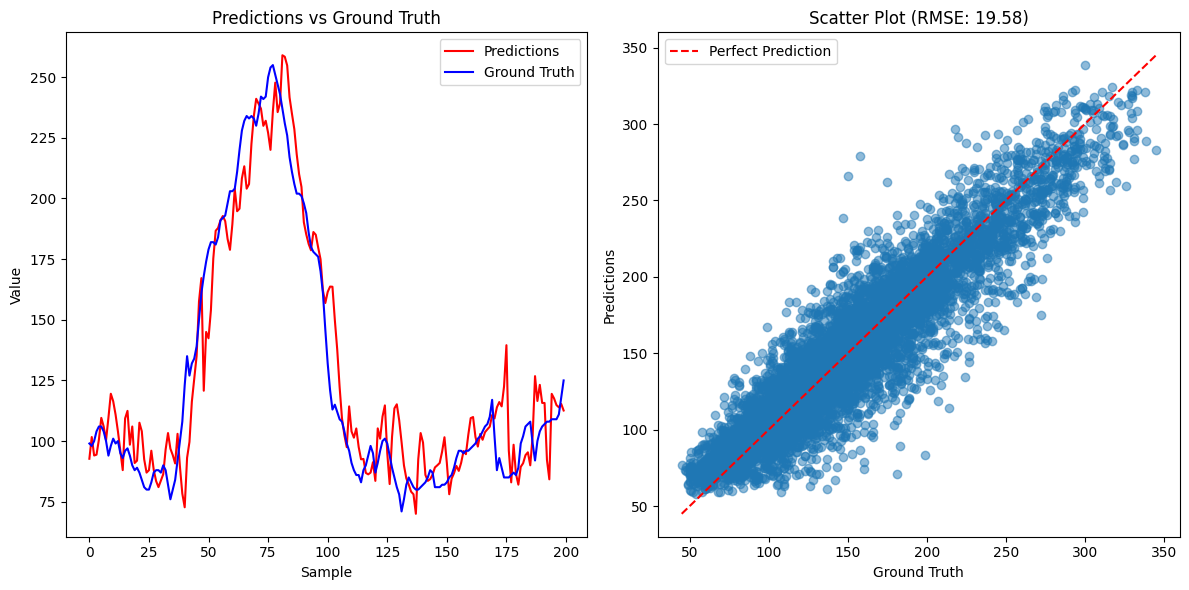

Model saved to saved_models_original_ohio\model_552-ws-training.xml.pth

Results for fold9:
RMSE: 19.58
MAE: 14.16
MAPE: 10.43%

Processing fold10...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4064.245243, Val Loss: 3904.210509
Epoch [6/200], Train Loss: 3090.230842, Val Loss: 956.798196
Epoch [11/200], Train Loss: 731.290687, Val Loss: 1187.234212
Epoch [16/200], Train Loss: 653.583975, Val Loss: 678.314294
Epoch [21/200], Train Loss: 639.777302, Val Loss: 549.476941
Epoch [26/200], Train Loss: 660.534962, Val Loss: 509.492699
Epoch [31/200], Train Loss: 633.515061, Val Loss: 550.394461
Epoch [36/200], Train Loss: 640.119892, Val Loss: 604.857823
Epoch [41/200], Train Loss: 673.098338, Val Loss: 505.482835
Epoch [46/200], Train Loss: 611.817428, Val Loss: 526.294496
Epoch [51/200], Train Loss: 718.859381, Val Loss: 563.560424
Epoch [56/200], Train Loss: 562.401615, Val Loss: 504.512539
Epoch [61/200], Train Loss: 553.103791, Val Loss: 548.473862
Epoch [66/200], Train Loss: 555.532806, Val Loss: 496.327846
Epoch [71/200], Train Loss: 553.509448, Val Loss: 545.205842
Epoch [76/200], Train Loss: 554.217040, Val Loss: 527.418004
Epoch [81/200], Train 

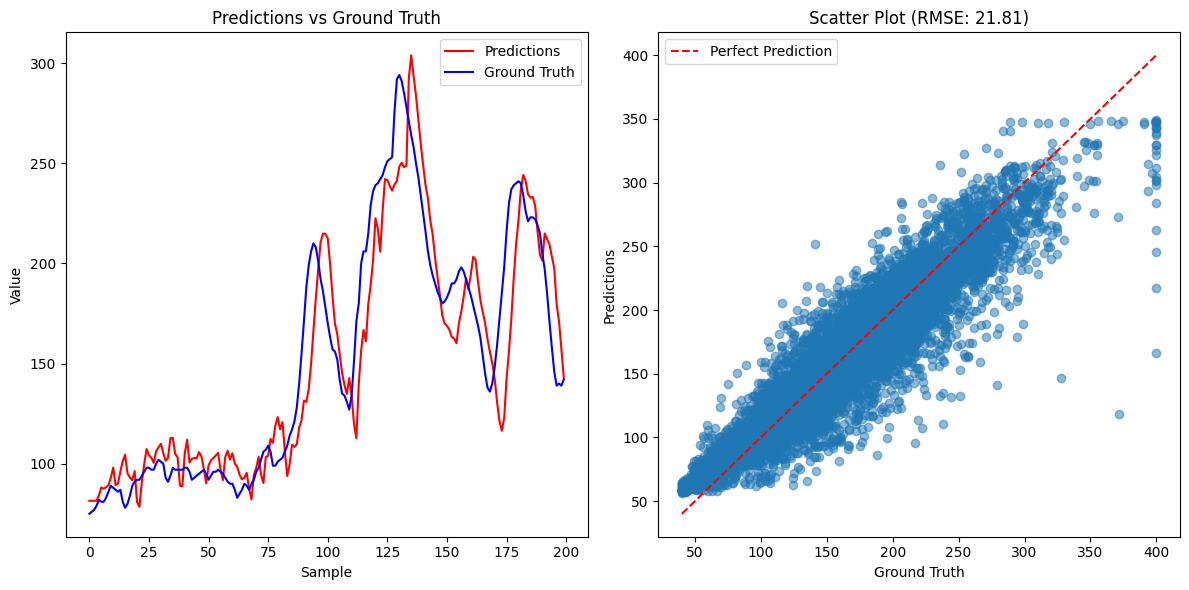

Model saved to saved_models_original_ohio\model_567-ws-training.xml.pth

Results for fold10:
RMSE: 21.81
MAE: 15.50
MAPE: 11.07%

Processing fold11...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 3947.788848, Val Loss: 3582.047758
Epoch [6/200], Train Loss: 1537.725284, Val Loss: 3221.258304
Epoch [11/200], Train Loss: 754.551958, Val Loss: 641.246502
Epoch [16/200], Train Loss: 637.857270, Val Loss: 645.209427
Epoch [21/200], Train Loss: 618.006776, Val Loss: 538.228319
Epoch [26/200], Train Loss: 621.376404, Val Loss: 544.575054
Epoch [31/200], Train Loss: 532.511025, Val Loss: 496.584433
Epoch [36/200], Train Loss: 537.938073, Val Loss: 496.328639
Epoch [41/200], Train Loss: 504.552636, Val Loss: 471.974990
Epoch [46/200], Train Loss: 509.841418, Val Loss: 488.035162
Epoch [51/200], Train Loss: 506.872520, Val Loss: 472.047433
Epoch [56/200], Train Loss: 503.020910, Val Loss: 469.981362
Epoch [61/200], Train Loss: 491.967999, Val Loss: 471.796129
Epoch [66/200], Train Loss: 491.889693, Val Loss: 528.345931
Epoch [71/200], Train Loss: 484.725328, Val Loss: 469.517121
Epoch [76/200], Train Loss: 483.989654, Val Loss: 489.920406
Epoch [81/200], Train 

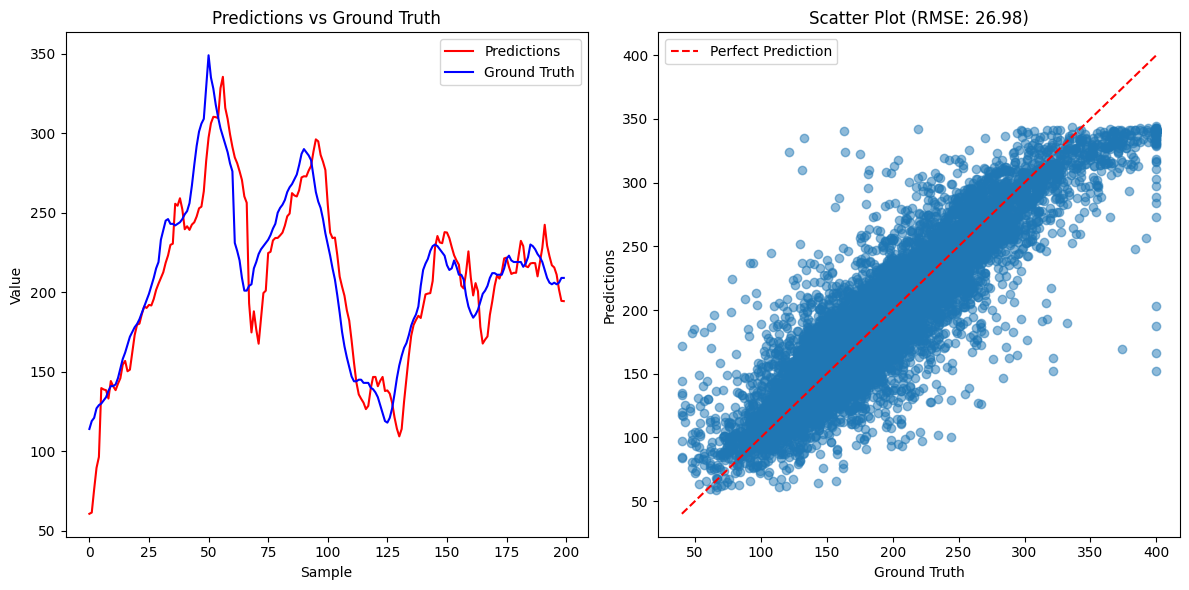

Model saved to saved_models_original_ohio\model_584-ws-training.xml.pth

Results for fold11:
RMSE: 26.98
MAE: 18.83
MAPE: 10.88%

Processing fold12...


c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4138.476382, Val Loss: 4028.700858
Epoch [6/200], Train Loss: 966.713609, Val Loss: 1063.147915
Epoch [11/200], Train Loss: 721.546607, Val Loss: 526.252999
Epoch [16/200], Train Loss: 712.623181, Val Loss: 506.178618
Epoch [21/200], Train Loss: 637.034725, Val Loss: 879.760813
Epoch [26/200], Train Loss: 673.594311, Val Loss: 588.066346
Epoch [31/200], Train Loss: 584.072081, Val Loss: 618.124740
Epoch [36/200], Train Loss: 590.126943, Val Loss: 531.230118
Epoch [41/200], Train Loss: 572.819974, Val Loss: 611.974779
Epoch [46/200], Train Loss: 544.682907, Val Loss: 489.034392
Epoch [51/200], Train Loss: 543.632031, Val Loss: 503.957009
Epoch [56/200], Train Loss: 540.757842, Val Loss: 496.384595
Epoch [61/200], Train Loss: 527.737961, Val Loss: 484.938707
Epoch [66/200], Train Loss: 526.338652, Val Loss: 477.365188
Epoch [71/200], Train Loss: 525.064608, Val Loss: 494.037696
Epoch [76/200], Train Loss: 525.352600, Val Loss: 508.828733
Epoch [81/200], Train L

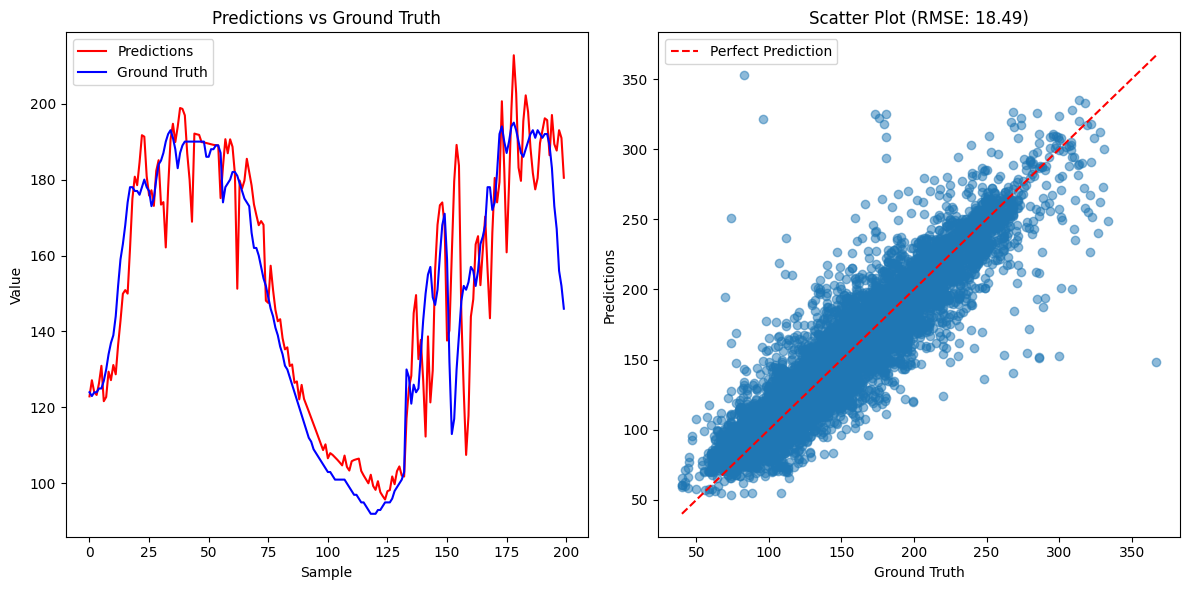

Model saved to saved_models_original_ohio\model_596-ws-training.xml.pth

Results for fold12:
RMSE: 18.49
MAE: 12.56
MAPE: 9.31%


In [ ]:
# Example usage
# 1. Set up paths and get file lists
folder_path_train_2018 = f"./OhioT1DM 2020/2018/train"
folder_path_train_2020 = "./OhioT1DM 2020/2020/train"
train_files_2018 = [f for f in os.listdir(folder_path_train_2018) if f.endswith('.xml')]
train_files_2020 = [f for f in os.listdir(folder_path_train_2020) if f.endswith('.xml')]

# 2. Create LOOCV splits
loocv_splits = create_loocv_splits(
    folder_path_train_2018,
    folder_path_train_2020,
    train_files_2018,
    train_files_2020
)

# 3. Initialize model
# model = TransformerEncoder(
#     num_layers=3,
#     d_model=64,
#     nhead=4,
#     input_dim=1,
#     dim_feedforward=256,
#     dropout=0.1
# )

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 4. Set hyperparameters
past_sequence_length = 12
future_offset = 6
batch_size = 64
max_interval_minutes = 30

# Get the items starting from fold9

fold_items = dict(list(loocv_splits.items())[1:])

# 5. Train and evaluate for each fold
for fold_name, fold_data in fold_items.items():
    model = TransformerEncoder(
        num_layers=1,
        d_model=512,
        nhead=4,
        input_dim=1,
        dim_feedforward=256,
        dropout=0.2
    )
    model = model.to(device)
    print(f"\nProcessing {fold_name}...")

    # Load and process training data
    train_dfs = []
    for train_file in fold_data['train']:
        df = load_ohio_series_train(train_file, "glucose_level", "value")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        train_dfs.append(df)

    # Create datasets
    train_series_list = []
    for df in train_dfs:
        series_list = split_into_continuous_series(df, past_sequence_length, future_offset, max_interval_minutes)
        train_series_list.extend(series_list)

    train_dataset, val_dataset = create_train_val_datasets(
        train_series_list,
        train_ratio=0.8,
        past_seq_len=past_sequence_length,
        future_offset=future_offset
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Train model
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=200,
        learning_rate=1e-3
    )

    # Evaluate on test data
    metrics = evaluate_and_save_metrics(
        model=model,
        test_file_path=fold_data['test'],
        save_dir='evaluation_metrics',
        past_sequence_length=past_sequence_length,
        future_offset=future_offset,
        batch_size=batch_size,
        max_interval_minutes=max_interval_minutes
    )

    # Save the trained model
    save_model(model, fold_data['test'][-19:], save_dir='saved_models_original_ohio')

    print(f"\nResults for {fold_name}:")
    print(f"RMSE: {metrics['rmse']:.2f}")
    print(f"MAE: {metrics['mae']:.2f}")
    print(f"MAPE: {metrics['mape']:.2f}%")

In [ ]:
fold_data['test'][-19:]

'559-ws-training.xml'

In [ ]:
save_model(model, fold_data['test'][-19:], save_dir='saved_models_original_ohio')

print(f"\nResults for {fold_name}:")
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"MAE: {metrics['mae']:.2f}")
print(f"MAPE: {metrics['mape']:.2f}%")

Model saved to saved_models_original_ohio\model_559-ws-training.xml.pth

Results for fold1:
RMSE: 24.60
MAE: 17.30
MAPE: 11.55%


In [ ]:
# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [ ]:
# Save model after training each fold
def save_model(model, fold_name, save_dir='saved_models'):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f'model_{fold_name}.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# Load model for evaluation
def load_model(fold_name, model_class=TransformerEncoder, save_dir='saved_models'):
    model_path = os.path.join(save_dir, f'model_{fold_name}.pth')

    # Initialize a new model with the same architecture
    model = model_class(
        num_layers=3,
        d_model=64,
        nhead=4,
        input_dim=1,
        dim_feedforward=256,
        dropout=0.1
    )

    # Load the saved weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    print(f"Model loaded from {model_path}")
    return model

In [ ]:
fold_name

'fold9'

In [ ]:
# Example usage
# 1. Set up paths and get file lists
folder_path_train_2018 = "/Users/baiyinglu/Desktop/AugmentedHealthLab/T1DEXI_Apr52024/try/OhioT1DM/2018/train"
folder_path_train_2020 = "/Users/baiyinglu/Desktop/AugmentedHealthLab/T1DEXI_Apr52024/try/OhioT1DM/2020/train"
train_files_2018 = [f for f in os.listdir(folder_path_train_2018) if f.endswith('.xml')]
train_files_2020 = [f for f in os.listdir(folder_path_train_2020) if f.endswith('.xml')]

# 2. Create LOOCV splits
loocv_splits = create_loocv_splits(
    folder_path_train_2018,
    folder_path_train_2020,
    train_files_2018,
    train_files_2020
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# 4. Set hyperparameters
past_sequence_length = 7
future_offset = 6
batch_size = 32
max_interval_minutes = 30

# Get the items starting from fold9
starting_fold = 9

Created 12 LOOCV splits

fold1:
Test file: 575-ws-training.xml
Number of training files: 11
Training files:
  563-ws-training.xml
  559-ws-training.xml
  588-ws-training.xml
  ...

fold2:
Test file: 563-ws-training.xml
Number of training files: 11
Training files:
  575-ws-training.xml
  559-ws-training.xml
  588-ws-training.xml
  ...

fold3:
Test file: 559-ws-training.xml
Number of training files: 11
Training files:
  575-ws-training.xml
  563-ws-training.xml
  588-ws-training.xml
  ...

fold4:
Test file: 588-ws-training.xml
Number of training files: 11
Training files:
  575-ws-training.xml
  563-ws-training.xml
  559-ws-training.xml
  ...

fold5:
Test file: 570-ws-training.xml
Number of training files: 11
Training files:
  575-ws-training.xml
  563-ws-training.xml
  559-ws-training.xml
  ...

fold6:
Test file: 591-ws-training.xml
Number of training files: 11
Training files:
  575-ws-training.xml
  563-ws-training.xml
  559-ws-training.xml
  ...

fold7:
Test file: 584-ws-training.xml
N

Model loaded from saved_models/model_fold9.pth
Test file: 596-ws-training.xml
Root Mean Square Error (RMSE): 18.83
Mean Absolute Error (MAE): 12.78
Mean Absolute Percentage Error (MAPE): 9.41%


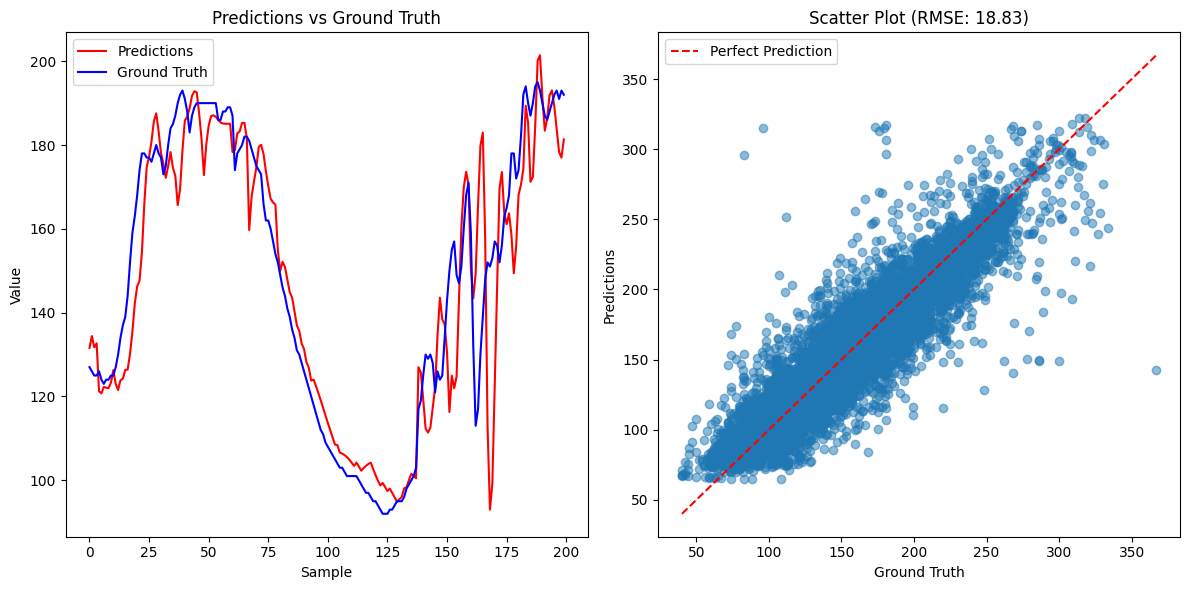


Results for fold9:
RMSE: 18.83
MAE: 12.78
MAPE: 9.41%


In [ ]:
# For a specific fold
fold_name = 'fold9'
fold_data = loocv_splits[fold_name]

# Load the saved model
model = load_model(fold_name)

metrics = evaluate_and_save_metrics(
    model=model,
    test_file_path=fold_data['test'],
    save_dir='evaluation_metrics',
    past_sequence_length=past_sequence_length,
    future_offset=future_offset,
    batch_size=batch_size,
    max_interval_minutes=max_interval_minutes
)

print(f"\nResults for {fold_name}:")
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"MAE: {metrics['mae']:.2f}")
print(f"MAPE: {metrics['mape']:.2f}%")